[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loading dataset...
Dataset shape: (17880, 18)
Dataset columns: ['job_id', 'title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'fraudulent']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  o

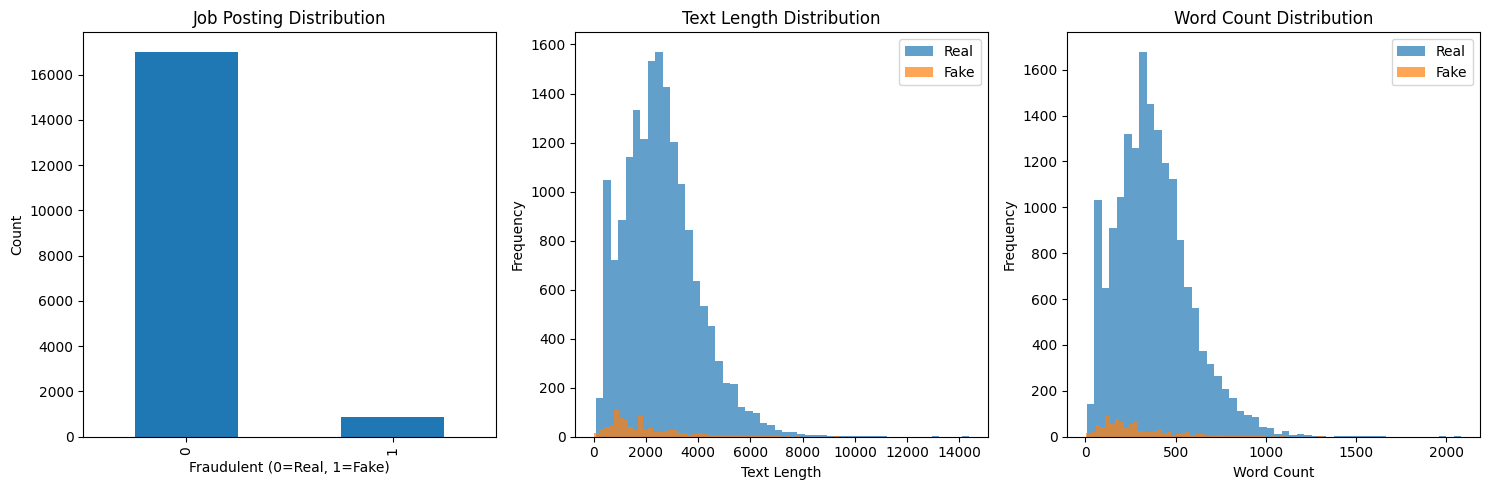

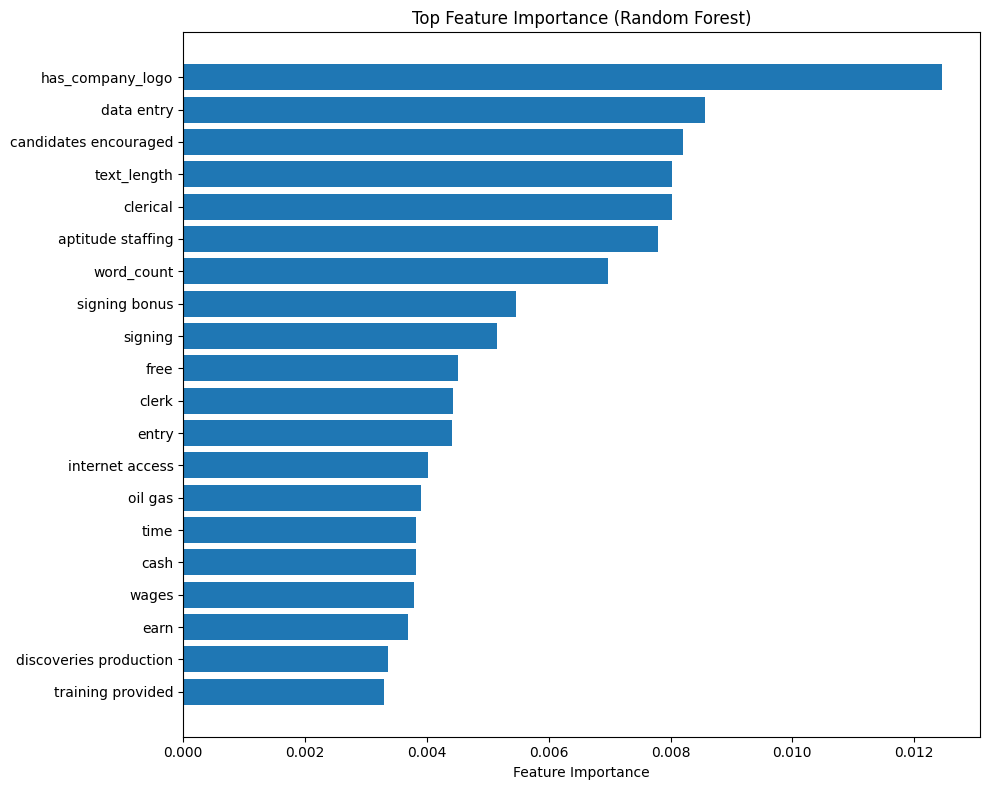

Saving model and vectorizer...
Model training completed successfully!
Files saved: fake_job_detector_model.pkl, tfidf_vectorizer.pkl, feature_columns.pkl, model_metadata.json

Testing with sample data:
Sample text: Work from home! Easy money! No experience required! Earn $5000 weekly! Contact us now!
Prediction: Fake
Probability: Real=0.490, Fake=0.510

Sample text (Real): Software Engineer III - Develop high-quality software for our platform. Requires 5+ years experience. BS in Computer Science.
Prediction: Real
Probability: Real=0.970, Fake=0.030


In [ ]:
# Fake Job Posting Detector - Complete Training Code (Google Colab)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import joblib
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load the dataset
print("Loading dataset...")

try:
    df = pd.read_csv('fake_job_postings.csv')
except FileNotFoundError:
    print("Error: 'fake_job_postings.csv' not found. Please upload the dataset file to your Colab environment.")
    
    exit() 
print(f"Dataset shape: {df.shape}")
print(f"Dataset columns: {df.columns.tolist()}")

# Display basic info about the dataset
print("\nDataset Info:")
print(df.info())
print("\nTarget distribution:")
print(df['fraudulent'].value_counts())

# Data preprocessing
print("\nStarting data preprocessing...")

# Fill missing values for relevant text columns
text_cols_to_fill = ['title', 'company_profile', 'description', 'requirements', 'benefits',
                     'location', 'department', 'salary_range', 'employment_type',
                     'required_experience', 'required_education', 'industry', 'function']
for col in text_cols_to_fill:
    if col in df.columns:
        df[col] = df[col].fillna('')
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")


# Combine text features
df['combined_text'] = (df['title'] + ' ' +
                      df['company_profile'] + ' ' +
                      df['description'] + ' ' +
                      df['requirements'] + ' ' +
                      df['benefits'] + ' ' +
                      df['location'] + ' ' +
                      df['department'] + ' ' +
                      df['salary_range'])

# Text preprocessing function
def preprocess_text(text):
    """
    Comprehensive text preprocessing function
    """
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove phone numbers
    text = re.sub(r'[\+]?[1-9]?[0-9]{7,15}', '', text)

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespaces
    text = ' '.join(text.split())

    return text

# Apply preprocessing
print("Applying text preprocessing...")
df['processed_text'] = df['combined_text'].apply(preprocess_text)

# Feature engineering
print("Creating additional features...")

# Text length features
df['text_length'] = df['processed_text'].apply(len)
df['word_count'] = df['processed_text'].apply(lambda x: len(x.split()))

# Binary features for missing/presence fields
# Use existing 'has_company_logo' column
df['has_company_logo'] = df['has_company_logo'].fillna(0).astype(int) # Ensure it's int and fill potential NaNs if any
df['has_questions'] = df['has_questions'].fillna(0).astype(int) # Use existing 'has_questions' column
df['has_salary_range'] = df['salary_range'].apply(lambda x: 1 if x else 0) # Check if salary_range is not empty
df['has_requirements'] = df['requirements'].apply(lambda x: 1 if x else 0) # Check if requirements is not empty
df['has_benefits'] = df['benefits'].apply(lambda x: 1 if x else 0) # Check if benefits is not empty


# Create employment type features
employment_types = ['full-time', 'part-time', 'contract', 'temporary', 'internship']
# Ensure 'employment_type' column exists before processing
if 'employment_type' in df.columns:
    for emp_type in employment_types:
        df[f'is_{emp_type}'] = df['employment_type'].str.contains(emp_type, case=False, na=False).astype(int)
else:
    print("Warning: 'employment_type' column not found. Skipping employment type features.")
    for emp_type in employment_types:
         df[f'is_{emp_type}'] = 0 # Create columns with default 0 if column is missing


# Create required experience features
# Ensure 'required_experience' column exists before processing
if 'required_experience' in df.columns:
    df['requires_experience'] = df['required_experience'].apply(lambda x: 1 if x else 0) # Check if required_experience is not empty
    df['entry_level'] = df['required_experience'].str.contains('entry', case=False, na=False).astype(int)
    df['senior_level'] = df['required_experience'].str.contains('senior|executive', case=False, na=False).astype(int)
else:
    print("Warning: 'required_experience' column not found. Skipping experience features.")
    df['requires_experience'] = 0
    df['entry_level'] = 0
    df['senior_level'] = 0


# Create education features
# Ensure 'required_education' column exists before processing
if 'required_education' in df.columns:
    df['requires_education'] = df['required_education'].apply(lambda x: 1 if x else 0) # Check if required_education is not empty
    df['requires_degree'] = df['required_education'].str.contains('degree|bachelor|master|phd', case=False, na=False).astype(int)
else:
     print("Warning: 'required_education' column not found. Skipping education features.")
     df['requires_education'] = 0
     df['requires_degree'] = 0


# Suspicious text patterns (common in fake job postings)
suspicious_patterns = [
    r'work from home',
    r'easy money',
    r'no experience required',
    r'flexible hours',
    r'immediate start',
    r'earn \$\d+',
    r'guaranteed income',
    r'part time',
    r'full time',
    r'make money',
    r'weekly pay'
]

for i, pattern in enumerate(suspicious_patterns):
    df[f'suspicious_{i}'] = df['processed_text'].str.contains(pattern, case=False, na=False).astype(int)

# Create final feature set
feature_columns = [
    'text_length', 'word_count', 'has_company_logo', 'has_questions',
    'has_salary_range', 'has_requirements', 'has_benefits', 'requires_experience',
    'entry_level', 'senior_level', 'requires_education', 'requires_degree'
] + [f'is_{emp_type}' for emp_type in employment_types] + [f'suspicious_{i}' for i in range(len(suspicious_patterns))]

# Filter feature_columns to only include columns actually created
feature_columns = [col for col in feature_columns if col in df.columns]

# Prepare data for training
X_text = df['processed_text']
X_features = df[feature_columns]
y = df['fraudulent']

print(f"Text features shape: {X_text.shape}")
print(f"Additional features shape: {X_features.shape}")
print(f"Target shape: {y.shape}")

# Split the data
X_text_train, X_text_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    X_text, X_features, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_text_train)}")
print(f"Test set size: {len(X_text_test)}")

# Create TF-IDF vectorizer
print("Creating TF-IDF features...")
tfidf = TfidfVectorizer(
    max_features=10000,
    min_df=2,
    max_df=0.8,
    stop_words='english',
    ngram_range=(1, 2)
)

# Fit and transform text data
X_text_train_tfidf = tfidf.fit_transform(X_text_train)
X_text_test_tfidf = tfidf.transform(X_text_test)

print(f"TF-IDF features shape: {X_text_train_tfidf.shape}")

# Combine text and additional features
from scipy.sparse import hstack

X_train_combined = hstack([X_text_train_tfidf, X_feat_train.values])
X_test_combined = hstack([X_text_test_tfidf, X_feat_test.values])

print(f"Combined features shape: {X_train_combined.shape}")

# Model training
print("Training models...")

# Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_combined, y_train)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_combined, y_train)

# Model evaluation
print("\nModel Evaluation:")

# Logistic Regression predictions
lr_pred = lr_model.predict(X_test_combined)
lr_accuracy = accuracy_score(y_test, lr_pred)

print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print("Logistic Regression Classification Report:")
print(classification_report(y_test, lr_pred))

# Random Forest predictions
rf_pred = rf_model.predict(X_test_combined)
rf_accuracy = accuracy_score(y_test, rf_pred)

print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))

# Choose the best model
if lr_accuracy > rf_accuracy:
    best_model = lr_model
    best_accuracy = lr_accuracy
    model_name = "Logistic Regression"
else:
    best_model = rf_model
    best_accuracy = rf_accuracy
    model_name = "Random Forest"

print(f"\nBest model: {model_name} with accuracy: {best_accuracy:.4f}")

# Visualization
plt.figure(figsize=(15, 5))

# Plot 1: Target distribution
plt.subplot(1, 3, 1)
df['fraudulent'].value_counts().plot(kind='bar')
plt.title('Job Posting Distribution')
plt.xlabel('Fraudulent (0=Real, 1=Fake)')
plt.ylabel('Count')

# Plot 2: Text length distribution
plt.subplot(1, 3, 2)
plt.hist(df[df['fraudulent']==0]['text_length'], alpha=0.7, label='Real', bins=50)
plt.hist(df[df['fraudulent']==1]['text_length'], alpha=0.7, label='Fake', bins=50)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Text Length Distribution')
plt.legend()

# Plot 3: Word count distribution
plt.subplot(1, 3, 3)
plt.hist(df[df['fraudulent']==0]['word_count'], alpha=0.7, label='Real', bins=50)
plt.hist(df[df['fraudulent']==1]['word_count'], alpha=0.7, label='Fake', bins=50)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Distribution')
plt.legend()

plt.tight_layout()
plt.show()

# Feature importance for Random Forest
if model_name == "Random Forest":
    # Ensure feature_columns used here matches the ones used for training
    feature_names = list(tfidf.get_feature_names_out()) + feature_columns
    # Filter feature_names to match the trained model's features if necessary
    # (This might require more advanced logic if feature_columns varies significantly)

    if len(feature_names) == rf_model.n_features_in_:
        feature_importance = rf_model.feature_importances_

        # Get top 20 features
        # Ensure top_indices are within the bounds of feature_importance array
        top_indices = np.argsort(feature_importance)[-min(20, len(feature_importance)):]
        top_features = [feature_names[i] for i in top_indices]
        top_importance = feature_importance[top_indices]

        plt.figure(figsize=(10, 8))
        plt.barh(range(len(top_features)), top_importance)
        plt.yticks(range(len(top_features)), top_features)
        plt.xlabel('Feature Importance')
        plt.title('Top Feature Importance (Random Forest)')
        plt.tight_layout()
        plt.show()
    else:
        print("Warning: Number of feature names does not match model features. Skipping feature importance plot.")


# Save the model and vectorizer
print("Saving model and vectorizer...")
joblib.dump(best_model, 'fake_job_detector_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(feature_columns, 'feature_columns.pkl')

# Save model metadata
model_metadata = {
    'model_type': model_name,
    'accuracy': best_accuracy,
    'feature_columns': feature_columns,
    'tfidf_max_features': 10000, # Note: Actual TF-IDF max_features might be lower if data size is small
    'preprocessing_steps': [
        'lowercase',
        'remove_html',
        'remove_urls',
        'remove_emails',
        'remove_phones',
        'remove_special_chars',
        'remove_extra_whitespace'
    ]
}

import json
with open('model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)

print("Model training completed successfully!")
print(f"Files saved: fake_job_detector_model.pkl, tfidf_vectorizer.pkl, feature_columns.pkl, model_metadata.json")

# Test the model with a sample
def predict_job_posting(text, company_profile="", location="", salary_range="", requirements="", benefits="",
                        employment_type="", required_experience="", required_education="", has_company_logo=0, has_questions=0):
    """
    Test function to predict if a job posting is fake
    """
    # Create test dataframe
    test_data = {
        'title': text, # Using the main text input as title for simplicity in this example, could refine
        'company_profile': company_profile,
        'description': text, # Using the main text input as description
        'requirements': requirements,
        'benefits': benefits,
        'location': location,
        'department': '', # Defaulting department
        'salary_range': salary_range,
        'employment_type': employment_type,
        'required_experience': required_experience,
        'required_education': required_education,
        'has_company_logo': has_company_logo,
        'has_questions': has_questions
        # Note: 'industry' and 'function' are not used in this simplified test function
    }

    test_df = pd.DataFrame([test_data])

    # Apply same preprocessing
    test_df['combined_text'] = (test_df['title'] + ' ' +
                              test_df['company_profile'] + ' ' +
                              test_df['description'] + ' ' +
                              test_df['requirements'] + ' ' +
                              test_df['benefits'] + ' ' +
                              test_df['location'] + ' ' +
                              test_df['department'] + ' ' +
                              test_df['salary_range'])

    test_df['processed_text'] = test_df['combined_text'].apply(preprocess_text)

    # Create features - Ensure these match the 'feature_columns' list used in training
    test_df['text_length'] = test_df['processed_text'].apply(len)
    test_df['word_count'] = test_df['processed_text'].apply(lambda x: len(x.split()))
    test_df['has_company_logo'] = test_df['has_company_logo'].fillna(0).astype(int) # Use the input value
    test_df['has_questions'] = test_df['has_questions'].fillna(0).astype(int) # Use the input value
    test_df['has_salary_range'] = test_df['salary_range'].apply(lambda x: 1 if x else 0)
    test_df['has_requirements'] = test_df['requirements'].apply(lambda x: 1 if x else 0)
    test_df['has_benefits'] = test_df['benefits'].apply(lambda x: 1 if x else 0)


    # Employment type features
    for emp_type in employment_types:
        test_df[f'is_{emp_type}'] = test_df['employment_type'].str.contains(emp_type, case=False, na=False).astype(int)

    # Experience and education features
    test_df['requires_experience'] = test_df['required_experience'].apply(lambda x: 1 if x else 0)
    test_df['entry_level'] = test_df['required_experience'].str.contains('entry', case=False, na=False).astype(int)
    test_df['senior_level'] = test_df['required_experience'].str.contains('senior|executive', case=False, na=False).astype(int)
    test_df['requires_education'] = test_df['required_education'].apply(lambda x: 1 if x else 0)
    test_df['requires_degree'] = test_df['required_education'].str.contains('degree|bachelor|master|phd', case=False, na=False).astype(int)

    # Suspicious patterns
    for i, pattern in enumerate(suspicious_patterns):
        test_df[f'suspicious_{i}'] = test_df['processed_text'].str.contains(pattern, case=False, na=False).astype(int)

    # Select only the feature columns that were used during training
    # Ensure test_df has all feature_columns, add missing ones with default 0 if needed
    for col in feature_columns:
        if col not in test_df.columns:
            test_df[col] = 0 # Add missing feature column with default 0

    test_features = test_df[feature_columns]


    # Transform text
    text_tfidf = tfidf.transform(test_df['processed_text'])

    # Get additional features - Ensure order matches training
    additional_features = test_features.values

    # Combine features
    from scipy.sparse import hstack
    combined_features = hstack([text_tfidf, additional_features])

    # Make prediction
    prediction = best_model.predict(combined_features)[0]
    probability = best_model.predict_proba(combined_features)[0]

    return prediction, probability

# Test with sample data
print("\nTesting with sample data:")
sample_text = "Work from home! Easy money! No experience required! Earn $5000 weekly! Contact us now!"
pred, prob = predict_job_posting(sample_text)
print(f"Sample text: {sample_text}")
print(f"Prediction: {'Fake' if pred == 1 else 'Real'}")
print(f"Probability: Real={prob[0]:.3f}, Fake={prob[1]:.3f}")

sample_text_real = "Software Engineer III - Develop high-quality software for our platform. Requires 5+ years experience. BS in Computer Science."
pred_real, prob_real = predict_job_posting(sample_text_real, company_profile="Leading Tech Company", salary_range="100k-150k", required_experience="Mid-Senior level", required_education="Bachelor's Degree")
print(f"\nSample text (Real): {sample_text_real}")
print(f"Prediction: {'Fake' if pred_real == 1 else 'Real'}")
print(f"Probability: Real={prob_real[0]:.3f}, Fake={prob_real[1]:.3f}")